# Credit Risk Analysis

### Import libraries

In [149]:
import os
import math
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)

### Load data

In [2]:
filepath = os.path.join('..', 'resources', 'df_criado_final.csv')
df = pd.read_csv(filepath, delimiter=',')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50390 entries, 0 to 50389
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Escolaridade                 14615 non-null  float64
 1   Renda Mensal Informal        9768 non-null   float64
 2   Dependentes                  50390 non-null  object 
 3   Estado Civil                 50390 non-null  int64  
 4   Idade                        50390 non-null  int64  
 5   Conta Poupanca               50390 non-null  object 
 6   Conta Salario                50390 non-null  object 
 7   Quant Adiantamento Deposito  21843 non-null  float64
 8   Qtd Fonte Renda              12806 non-null  float64
 9   Cheque Sem Fundo             50390 non-null  object 
 10  Conta Conjunta               50390 non-null  object 
 11  Valor Conta Corrente         0 non-null      float64
 12  Valor Conta Poupanca         0 non-null      float64
 13  Valor Emprestimo

In [4]:
df.head()

,Escolaridade,Renda Mensal Informal,Dependentes,Estado Civil,Idade,Conta Poupanca,Conta Salario,Quant Adiantamento Deposito,Qtd Fonte Renda,Cheque Sem Fundo,...,Valor Emprestimo,Multa,Juros,Valor Emprestimo Atualizado,PAGO,Controle,ID,Genero,Data,Estado
0,NaN,NaN,S,2,36,S,N,NaN,NaN,N,...,8174.32,263.25,5844.98,14282.55,1,1,1328587.0,1,2020-01-01,57
1,1.0,1894.5078,N,2,39,S,N,2.0,1.0,S,...,41775.63,1607.29,7652.26,51035.18,1,1,1424254.0,1,2020-01-01,59
2,1.0,NaN,S,2,26,S,N,NaN,1.0,S,...,522940.27,24860.40,319315.62,867116.29,1,1,1438519.0,0,2020-01-01,56
3,NaN,NaN,N,8,23,N,N,NaN,NaN,N,...,1593.00,21472.36,2967.48,26032.84,1,1,1426138.0,1,2020-01-01,56
4,NaN,NaN,S,2,33,S,N,NaN,NaN,N,...,2078.97,19.44,46.35,2144.76,1,1,1474504.0,0,2020-01-01,59


### Remove features not related to credit risk

In [5]:
not_related_features = ['ID']
df = df.drop(columns=not_related_features, errors='ignore')

### Analyze amount of different values for each feature

In [6]:
{ col: df[col].unique().size for col in df.columns }

{'Escolaridade': 4,
 'Renda Mensal Informal': 2342,
 'Dependentes': 2,
 'Estado Civil': 9,
 'Idade': 77,
 'Conta Poupanca': 2,
 'Conta Salario': 2,
 'Quant Adiantamento Deposito': 16,
 'Qtd Fonte Renda': 4,
 'Cheque Sem Fundo': 2,
 'Conta Conjunta': 2,
 'Valor Conta Corrente': 1,
 'Valor Conta Poupanca': 1,
 'Valor Emprestimo': 28577,
 'Multa': 33777,
 'Juros': 42139,
 'Valor Emprestimo Atualizado': 43191,
 'PAGO': 2,
 'Controle': 1,
 'Genero': 2,
 'Data': 1,
 'Estado': 4}

### Remove features with unique values

In [7]:
unique_value_features = [col for col in df.columns if df[col].unique().size == 1]
df = df.drop(columns=unique_value_features, errors='ignore')

### Analyze proportion of missing values of each feature

In [8]:
df.isnull().mean().sort_values(ascending=False)

Renda Mensal Informal          0.806152
Qtd Fonte Renda                0.745862
Escolaridade                   0.709962
Quant Adiantamento Deposito    0.566521
Valor Emprestimo Atualizado    0.000000
Juros                          0.000000
Multa                          0.000000
Valor Emprestimo               0.000000
Conta Conjunta                 0.000000
Cheque Sem Fundo               0.000000
Genero                         0.000000
Conta Salario                  0.000000
Conta Poupanca                 0.000000
Idade                          0.000000
Estado Civil                   0.000000
Dependentes                    0.000000
PAGO                           0.000000
Estado                         0.000000
dtype: float64

### Removing columns with a proportion of missing values above a threshold

In [9]:
above_percentage_nan_features = [col for col in df.columns if df[col].isnull().mean() >= 0.8]
df = df.drop(columns=above_percentage_nan_features, errors='ignore')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50390 entries, 0 to 50389
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Escolaridade                 14615 non-null  float64
 1   Dependentes                  50390 non-null  object 
 2   Estado Civil                 50390 non-null  int64  
 3   Idade                        50390 non-null  int64  
 4   Conta Poupanca               50390 non-null  object 
 5   Conta Salario                50390 non-null  object 
 6   Quant Adiantamento Deposito  21843 non-null  float64
 7   Qtd Fonte Renda              12806 non-null  float64
 8   Cheque Sem Fundo             50390 non-null  object 
 9   Conta Conjunta               50390 non-null  object 
 10  Valor Emprestimo             50390 non-null  float64
 11  Multa                        50390 non-null  float64
 12  Juros                        50390 non-null  float64
 13  Valor Emprestimo

### Analyze proportion of target values

In [11]:
df['PAGO'].value_counts() / df.shape[0]

1    0.790891
0    0.209109
Name: PAGO, dtype: float64

In [12]:
cat = ['Escolaridade', 'Dependentes', 'Estado Civil', 'Conta Poupanca', 'Conta Salario', 'Qtd Fonte Renda', 'Cheque Sem Fundo', 'Conta Conjunta', 'Genero', 'Estado']
num = ['Idade', 'Valor Emprestimo', 'Multa', 'Juros', 'Valor Emprestimo Atualizado']

### Analyze numerical features

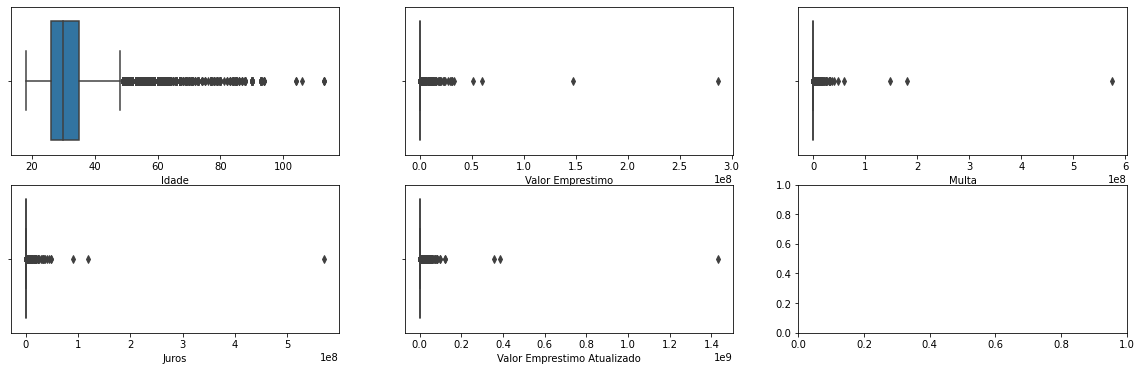

In [13]:
ncols = 3
nrows = 2
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20,6))

for i, col in enumerate(num):
    c = i % ncols
    r = i // ncols
    sns.boxplot(df[col], ax=ax[r][c])

### Idade

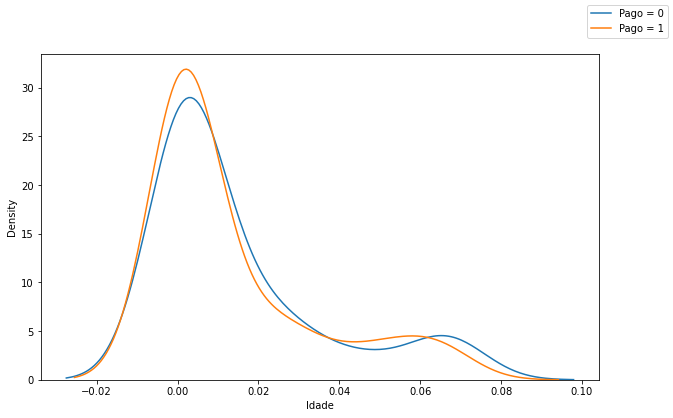

In [14]:
df_0_vc = df[df['PAGO'] == 0]['Idade'].value_counts(normalize=True)
df_1_vc = df[df['PAGO'] == 1]['Idade'].value_counts(normalize=True)

fig = plt.figure(figsize=(10,6))

sns.distplot(df_0_vc, hist=False)
sns.distplot(df_1_vc, hist=False)

fig.legend(labels=['Pago = 0','Pago = 1'])
plt.show()

### Valor Emprestimo

1593.00       4241
2093.00          4
2443.00          3
2030.33          2
59430.82         2
              ... 
55605.41         1
9452.70          1
1025195.69       1
87592.92         1
3520.00          1
Name: Valor Emprestimo, Length: 6265, dtype: int64


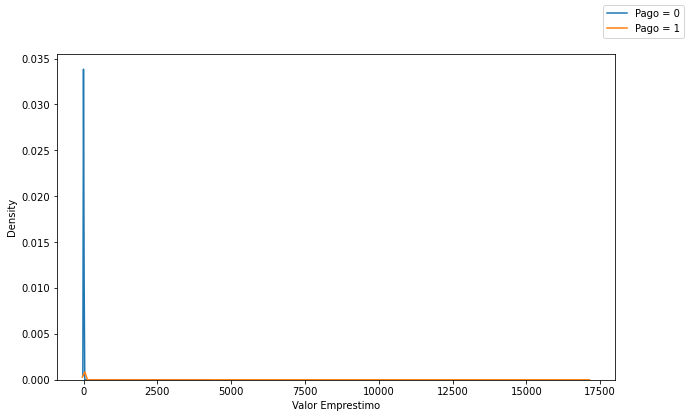

In [15]:
df_0_vc = df[df['PAGO'] == 0]['Valor Emprestimo'].value_counts()
df_1_vc = df[df['PAGO'] == 1]['Valor Emprestimo'].value_counts()
print(df_0_vc[df_0_vc > 0])

fig = plt.figure(figsize=(10,6))

sns.distplot(df_0_vc, hist=False)
sns.distplot(df_1_vc, hist=False)

fig.legend(labels=['Pago = 0','Pago = 1'])
plt.show()

(-285247.03599999996, 5737297.493]    10477
(5737297.493, 11473054.186]              23
(11473054.186, 17208810.878]             19
(17208810.878, 22944567.571]              7
(28680324.264, 34416080.957]              5
(22944567.571, 28680324.264]              2
(143395458.12, 149131214.813]             1
(45887594.342, 51623351.035]              1
(57359107.728, 63094864.421]              1
(281053618.747, 286789375.44]             1
Name: Valor Emprestimo, dtype: int64


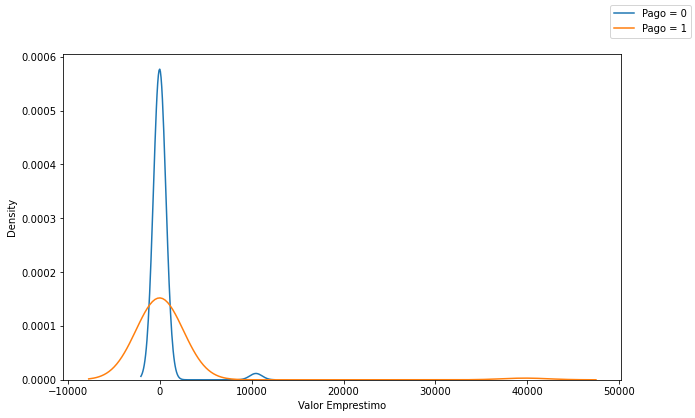

In [16]:
df_0_vc = df[df['PAGO'] == 0]['Valor Emprestimo'].value_counts(bins=50)
df_1_vc = df[df['PAGO'] == 1]['Valor Emprestimo'].value_counts(bins=50)
print(df_0_vc[df_0_vc > 0])

fig = plt.figure(figsize=(10,6))

sns.distplot(df_0_vc, hist=False)
sns.distplot(df_1_vc, hist=False)

fig.legend(labels=['Pago = 0','Pago = 1'])
plt.show()

In [17]:
df_0 = df[df['PAGO'] == 0]['Valor Emprestimo']
df_1 = df[df['PAGO'] == 1]['Valor Emprestimo']

print(df_0.quantile(np.arange(0, 1, 0.05)))
print(df_1.quantile(np.arange(0, 1, 0.05)))

0.00      1540.800
0.05      1593.000
0.10      1593.000
0.15      1593.000
0.20      1593.000
0.25      1593.000
0.30      1593.000
0.35      1593.000
0.40      1593.000
0.45      2222.136
0.50      3122.680
0.55      4394.304
0.60      6593.054
0.65      9879.862
0.70     15328.902
0.75     22805.510
0.80     34122.348
0.85     50728.886
0.90     76834.024
0.95    227481.032
Name: Valor Emprestimo, dtype: float64
0.00     1431.000
0.05     1593.000
0.10     1593.000
0.15     1593.000
0.20     1593.000
0.25     1593.000
0.30     1593.000
0.35     1593.000
0.40     1593.000
0.45     1728.990
0.50     2193.000
0.55     2628.904
0.60     3102.140
0.65     3756.348
0.70     4622.736
0.75     5890.640
0.80     7734.372
0.85    10928.338
0.90    17705.234
0.95    37087.812
Name: Valor Emprestimo, dtype: float64


### Analyze categorical features

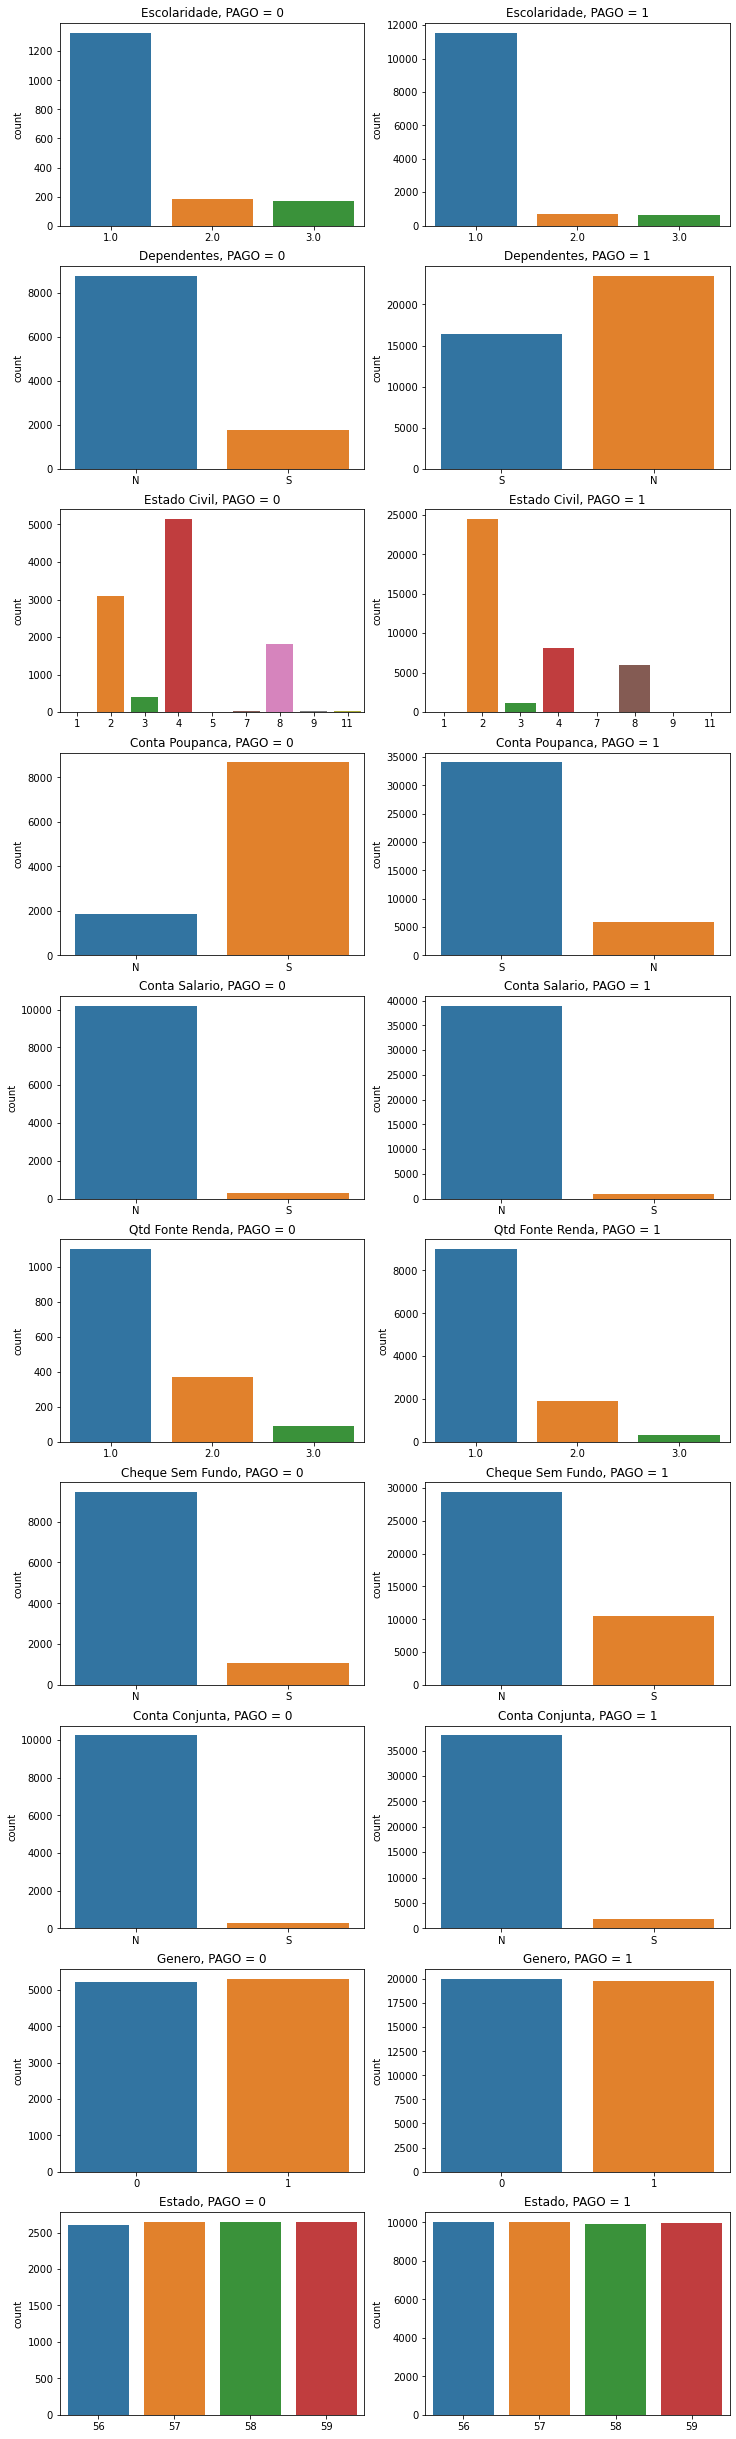

In [18]:
ncols = 2
nrows = 10
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 44))

for i, col in enumerate(cat):
    c = (i * 2) % ncols
    r = (i * 2) // ncols
    for p in [0, 1]:
        ax[r][c+p].title.set_text('%s, PAGO = %s' % (col, p))
        sns.countplot(df[df['PAGO'] == p][col].values, x=col, ax=ax[r][c+p])

### Notes

- if 'Dependentes' == 'S', more likely to 'PAGO' == 1;
- if 'Estado Civil' == '2', more likely to 'PAGO' == 1;
- if 'Estado Civil' == '4', more likely to 'PAGO' == 0;
- if 'Cheque Sem Fundo' == '1', more likely to 'PAGO' == 1;

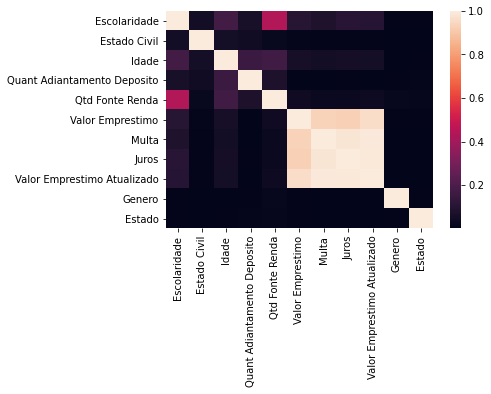

In [19]:
corr_matrix = df.drop('PAGO', axis=1).corr().abs()
sns.heatmap(corr_matrix)

In [20]:
corr_upper_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
high_corr_cols = [col for col in corr_upper_matrix.columns if any(corr_upper_matrix[col] > 0.95)]

print(high_corr_cols)
df = df.drop(columns=high_corr_cols, errors='ignore')

['Juros', 'Valor Emprestimo Atualizado']


### Handle missing values

In [21]:
df = df.fillna(0)

In [22]:
cat = ['Escolaridade', 'Dependentes', 'Estado Civil', 'Conta Poupanca', 'Conta Salario', 'Qtd Fonte Renda', 'Cheque Sem Fundo', 'Conta Conjunta', 'Genero', 'Estado']
num = ['Idade', 'Valor Emprestimo', 'Multa']

### Split dataset

In [23]:
X = df.drop('PAGO', axis=1)
y = df['PAGO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Feature selection (categorical)

In [24]:
X_train_cat = X_train[cat].copy()

chi2 = { 'features': [], 'p_values': [] }
for col in cat:
    _, p_value, _, _ = scipy.stats.chi2_contingency(pd.crosstab(y_train, X_train_cat[col]))
    chi2['features'].append(col)
    chi2['p_values'].append(p_value)
    
df_chi2 = pd.DataFrame(data=chi2).sort_values(by='p_values', ascending=True)
df_chi2

,features,p_values
1,Dependentes,0.000000e+00
2,Estado Civil,0.000000e+00
6,Cheque Sem Fundo,1.855636e-212
0,Escolaridade,4.354686e-206
5,Qtd Fonte Renda,8.393099e-145
7,Conta Conjunta,8.754044e-18
3,Conta Poupanca,5.484030e-14
4,Conta Salario,3.181974e-06
8,Genero,1.033840e-01
9,Estado,6.796148e-01


### Feature selection (numerical)

In [25]:
X_train_num = X_train[num].copy()

F_statistic, p_values = f_classif(X_train_num, y_train)
ANOVA_F = { 'features': X_train_num.columns.values, 'F_score': F_statistic, 'p_values': p_values }

df_ANOVA_F = pd.DataFrame(data=ANOVA_F).sort_values(by='F_score', ascending=False)
df_ANOVA_F

,features,F_score,p_values
2,Multa,155.897606,1.037940e-35
1,Valor Emprestimo,152.345137,6.159799e-35
0,Idade,19.430252,1.046104e-05


In [26]:
cat_best = df_chi2[df_chi2['p_values'] < 0.05]['features'].values.tolist()
num_best = df_ANOVA_F[df_ANOVA_F['p_values'] < 0.05]['features'].values.tolist()

X_train = X_train[cat_best + num_best]
X_test = X_test[cat_best + num_best]

X_train.head()

,Dependentes,Estado Civil,Cheque Sem Fundo,Escolaridade,Qtd Fonte Renda,Conta Conjunta,Conta Poupanca,Conta Salario,Multa,Valor Emprestimo,Idade
36935,N,2,S,1.0,1.0,N,S,N,1629.75,4852.49,28
393,S,2,N,1.0,0.0,N,S,N,97.26,4024.45,30
47806,N,4,N,0.0,0.0,N,S,N,9600.99,20794.94,26
32448,N,2,N,0.0,0.0,N,S,N,297.58,9032.51,30
995,N,4,N,0.0,0.0,N,S,N,12.00,1893.00,46


### One-hot encoding categorical features

In [27]:
for col in cat_best:
    one_hot_col = pd.get_dummies(df[col], prefix=col)
    
    X_train = X_train.drop(col, axis=1).join(one_hot_col)
    X_test = X_test.drop(col, axis=1).join(one_hot_col)
    
X_train.head()

,Multa,Valor Emprestimo,Idade,Dependentes_N,Dependentes_S,Estado Civil_1,Estado Civil_2,Estado Civil_3,Estado Civil_4,Estado Civil_5,...,Qtd Fonte Renda_0.0,Qtd Fonte Renda_1.0,Qtd Fonte Renda_2.0,Qtd Fonte Renda_3.0,Conta Conjunta_N,Conta Conjunta_S,Conta Poupanca_N,Conta Poupanca_S,Conta Salario_N,Conta Salario_S
36935,1629.75,4852.49,28,1,0,0,1,0,0,0,...,0,1,0,0,1,0,0,1,1,0
393,97.26,4024.45,30,0,1,0,1,0,0,0,...,1,0,0,0,1,0,0,1,1,0
47806,9600.99,20794.94,26,1,0,0,0,0,1,0,...,1,0,0,0,1,0,0,1,1,0
32448,297.58,9032.51,30,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,1,1,0
995,12.00,1893.00,46,1,0,0,0,0,1,0,...,1,0,0,0,1,0,0,1,1,0


### Scale numerical features

In [28]:
X_train[num_best] = StandardScaler().fit_transform(X_train[num_best])
X_test[num_best] = StandardScaler().fit_transform(X_test[num_best])

X_train.head()

,Multa,Valor Emprestimo,Idade,Dependentes_N,Dependentes_S,Estado Civil_1,Estado Civil_2,Estado Civil_3,Estado Civil_4,Estado Civil_5,...,Qtd Fonte Renda_0.0,Qtd Fonte Renda_1.0,Qtd Fonte Renda_2.0,Qtd Fonte Renda_3.0,Conta Conjunta_N,Conta Conjunta_S,Conta Poupanca_N,Conta Poupanca_S,Conta Salario_N,Conta Salario_S
36935,-0.035598,-0.042226,-0.434888,1,0,0,1,0,0,0,...,0,1,0,0,1,0,0,1,1,0
393,-0.036783,-0.043077,-0.200002,0,1,0,1,0,0,0,...,1,0,0,0,1,0,0,1,1,0
47806,-0.029433,-0.025839,-0.669774,1,0,0,0,0,1,0,...,1,0,0,0,1,0,0,1,1,0
32448,-0.036628,-0.037929,-0.200002,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,1,1,0
995,-0.036849,-0.045268,1.679088,1,0,0,0,0,1,0,...,1,0,0,0,1,0,0,1,1,0


### Training

In [141]:
models_search = {
    'random_forest': RandomizedSearchCV(
        estimator=RandomForestClassifier(),
        param_distributions={
            'bootstrap': [True, False],
            'max_depth': [3, 5, 10, 20, 50],
            'n_estimators': [50, 100, 200, 500],
            'max_features': ['auto', 'sqrt'],
            'class_weight': ['balanced', None],
            'random_state': [42] },
        n_iter=10, cv=5, verbose=5, n_jobs=-1),
    
    'decision_tree': RandomizedSearchCV(
        estimator=DecisionTreeClassifier(),
        param_distributions={
            'criterion': ['entropy', 'gini'],
            'max_depth': [3, 5, 10, 20],
            'max_features': np.arange(1, X_train.shape[1]),
            'class_weight': ['balanced', None],
            'random_state': [42] },
        n_iter=10, cv=5, verbose=5, n_jobs=-1),
    
    'logistic_regression': RandomizedSearchCV(
        estimator=LogisticRegression(),
        param_distributions={
            'C': np.linspace(0.1, 10, 20),
            'penalty': ['l1', 'l2'],
            'class_weight': ['balanced', None],
            'random_state': [42],
            'solver': ['liblinear'] },
        n_iter=10, cv=5, verbose=5, n_jobs=-1) }

In [156]:
def train_search(name, model_search):
    print('training %s' % name)
    
    model_search.fit(X_train, y_train)
    model = model_search.best_estimator_
    
    return model

models = { name: train_search(name, model_search) for (name, model_search) in models_search.items() }

In [158]:
ensemble = RandomizedSearchCV(
    estimator=VotingClassifier(estimators=list(models.items())),
    param_distributions={ 'voting': ['hard', 'soft'] },
    n_iter=10, cv=5, verbose=5, n_jobs=-1)

models['ensemble'] = train_search('ensemble', ensemble)

training ensemble
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   42.9s remaining:   28.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   53.7s finished


In [164]:
def evaluate(model):
    pred = model.predict(X_test)
    pred_mean = pred.mean()
    
    cm = confusion_matrix(y_test, pred)
    
    acc = accuracy_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    
    tp, fp, fn, tn = cm.flatten()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = (2 * precision * recall) / (precision + recall)
    
    return { 'pred': pred, 'pred_mean': pred_mean, 'confusion_matrix': cm, 'accuracy': acc, 'auc': auc, 'precision': precision, 'recall': recall, 'f_score': f_score }

results = { name: evaluate(model) for (name, model) in models.items() }

In [165]:
df_results = pd.DataFrame(results).transpose()
df_results.drop(columns=['pred', 'confusion_matrix']).astype(float).round(decimals=4)

,pred_mean,accuracy,auc,precision,recall,f_score
random_forest,0.3728,0.5134,0.6322,0.8363,0.2788,0.4181
decision_tree,0.2270,0.3964,0.5835,0.9051,0.2448,0.3854
logistic_regression,0.9780,0.8082,0.5455,0.0940,0.8919,0.1700
ensemble,0.5827,0.6772,0.6952,0.7262,0.3638,0.4847


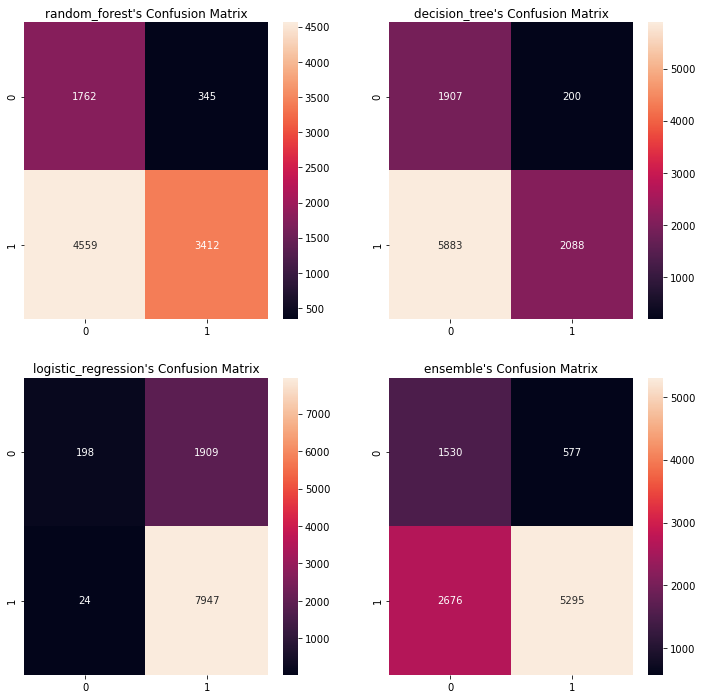

In [163]:
ncols = 2
nrows = 2
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 12))

for i, (name, result) in enumerate(results.items()):
    c = i % ncols
    r = i // ncols
    cm = result['confusion_matrix']
    
    ax[r][c].title.set_text('%s\'s Confusion Matrix' % name)
    sns.heatmap(cm, annot=True, fmt='g', ax=ax[r][c])